# Chapter 1: The contrast-dependence of spatial frequency tuning
Here, we'll organize (better than has been organized in the predecesor notebooks [descrAnalysisV1-allExps, V1_clustering, and descrAnalysisLGN]) the analysis for chapter 1 of my thesis.

Last access (y.m.d): 21.10.12  
Last update (y.m.d): 21.10.12

### Table of contents

- Initialize  
- Gather  
- Distribution of tuning measures **(0)**
  - model free measures  
  - comparison with derived measures  
  - comparison with Cavanuagh, other datasets  
- Tuning shifts as scatter plots, ratios (hist) **(1)**
  - Preferred spatial frequency with contrast 
  - Center of mass with contrast 
  - SFBW with contrast 
  - sfVariance with contrast 
- Trajectories of tuning metrics across contrasts  **(2)**

## Initialize

In [3116]:
import pandas as pd
import pdb
import warnings
warnings.filterwarnings(action='once')

import numpy as np
import os
import helper_fcns as hf
# import model_responses as mr
import scipy.stats as ss
import scipy.odr.odrpack as odrpack
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

In [3117]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 8
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 8

rcParams['xtick.major.width'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 5
rcParams['ytick.minor.width'] = 2

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

## Gather data

Now, let's create a large list which will combine data/fits/analyses from all cells for all of the above experiments. For each cell, let's keep track of:
* "meta" parameters:
    * which experiment directory
    * which dataList, fitList, descrFit, rvcFit
    * which cell number within those lists
    * which experiment index?
    * which stimulus values (i.e. dispersions, sfs, contrasts)
* inferred parameters:
    * prefSf (for all conditions), along with % var explained
    * c50 (again, for all conditions)
* model parameters
    * fit parameters, loss value for weighted and flat

In [3118]:
whichArea = 'LGN'; # 'LGN' or 'V1'
wMods = 1 if whichArea == 'V1' else 0; # if wMods 
wModStr = '_wMods' if wMods else ''

toGroup = 'simple' if whichArea == 'V1' else 'triType'; # triType is 'magno', 'parvo', 'other'

fitBase = '210914'; # descriptive fits (rvc,SF tuning)
#fitBase = '210503'; # descriptive fits (rvc,SF tuning)
fitBaseMod = '210331'; # model fits

if whichArea == 'LGN':
    suffix = '%s%s_211012_vT60_dvT60' % (whichArea, wModStr)
else:
    suffix = '%s%s_210921_vT70_dvT70' % (whichArea, wModStr)
# suffix = '%s%s_210826_vT60_dvT60' % (whichArea, wModStr)

# suffix = 'V1_wMods_210429_vT70_dvT60'
# suffix = 'V1_take2_210331_vT70_dvT60'
# suffix = 'V1_210331_vT70_dvT60'
# suffix = 'V1_200609_vT70_dvT60'
try:
    jointList = hf.np_smart_load(base_dir + 'jointList_%s.npy' % suffix)
    if jointList == []:
        jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
except: # if it wasn't pickled, then we'll need to just load without the .item which is implicit in hf.np_smart_load
    jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
#     jointList = np.load(base_dir + 'jointList_%s.npy' % suffix);


saveName = 'figures/reports/ch1/%s/' % (suffix) # for one save name for all figures
save_loc = base_dir + saveName;

#### Trim the jointList on some criteria?

In [3119]:
# A: must have at least one single grating tuning curve which has non-nan varExpl (i.e. > VarExplThresh) 
# altA: single grating tuning curve at high contrast must have non-nan varExpl (i.e. > varExplThresh) 
# --- for the diff-of-gauss tuning fit

# Get the keys as ints for easy indexing
keysAsInts = np.array([int(x) for x in jointList.keys()])

prevCells = len(jointList)
critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['sfVarExpl'][0,-1]))[0]) > 0 for x in sorted(jointList.keys())])[0]
# critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['sfVarExpl'][0,:]))[0]) > 0 for x in sorted(jointList.keys())])[0]


jointListTrim = {key: jointList[keysAsInts[key]] for key in critA}
jointList = jointListTrim

remCells = len(jointList)

nCut = prevCells-remCells

print('We cut %d cells (%.2f%% of the original %d)' % (nCut, 100*nCut/prevCells, prevCells))

# also get the keys as ints for easy indexing
keysAsInts = np.array([int(x) for x in jointList.keys()])

We cut 20 cells (17.39% of the original 115)


<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


Now, put this list of dictionaries into a pandas dataframe for better plotting (hacky)

- First, create a pandas data frame
- Then, json "normalize" each top-level dictionary (e.g. metadata) into it's own dataframe
- Finally, combine _those_ dataframes into one

In [3120]:
ohno = pd.DataFrame.from_dict(jointList) #, orient='index')

meta = pd.json_normalize([ohno[x]['metadata'] for x in sorted(ohno.keys())])
metr = pd.json_normalize([ohno[x]['metrics'] for x in sorted(ohno.keys())])
modl = pd.json_normalize([ohno[x]['model'] for x in sorted(ohno.keys())])
# supr = pd.json_normalize([ohno[x]['superpos'] for x in sorted(ohno.keys())])
basc = pd.json_normalize([ohno[x]['basics'] for x in sorted(ohno.keys())])

mega = pd.concat((meta, metr, modl, basc), axis=1)

In [3121]:
colors = [];

# classify as simple or complex [FOR USE WITH V1]
simple = mega['f1f0_ratio'] > 1
msk = np.copy(simple)
simple[~msk] = 'complex'
simple[msk] = 'simple'
mega['simple'] = simple

if whichArea == 'LGN':
    cellTypes = mega['cellType'];
    non_mp = np.logical_and(~(cellTypes=='parvo'), ~(cellTypes=='magno'))
    cellTypes[non_mp] = 'other'
    
    mega['triType'] = cellTypes;
    
# get color scheme
cnt = 0;
grp_names = [];
for nm, group in mega.groupby(toGroup):
    cnt += 1;
    grp_names.append(nm)
    
# colors = cm.viridis(np.linspace(0.15, 0.95, cnt))
colors = sns.color_palette('colorblind', n_colors=cnt-1)
colors.append((0,0,0)); # add black!

alph= 0.8/cnt
alphHist = 1; # the bins are non-overlapping now, so no need for transparency

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


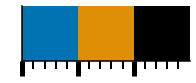

In [3122]:
sns.palplot(colors)

## 00. Set any overall parameters
For example, are we getting descr fits or DoG fits?

In [3123]:
isDog = 0; # 0 if descr; 1 if DoG
dog_suffix = 'dog_' if isDog else '';
dog_suffix_sv = '_dog' if isDog else '';

## 0. Distribution of tuning measures


In [3124]:
com, _ = hf.jl_get_metric_byCon(jointList, 'sfCom', conVal=1.0, disp=0, valIsFrac=True)
var, _ = hf.jl_get_metric_byCon(jointList, 'sfVar', conVal=1.0, disp=0, valIsFrac=True)

pSf, _ = hf.jl_get_metric_byCon(jointList, 'boot_%spSf_mn' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
pSf_stdLog, _ = hf.jl_get_metric_byCon(jointList, 'boot_%spSf_stdLog' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
sf70, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_mn' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
sf70_stdLog, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_stdLog' % dog_suffix, conVal=1.0,
                                        disp=0, valIsFrac=True)
sf70_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_mn' % dog_suffix, conVal=0.33, conTol=0.065,
                                       disp=0, valIsFrac=True)
sf70_stdLog_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_stdLog' % dog_suffix, conTol=0.065,
                                              conVal=0.33, disp=0, valIsFrac=True)

bwHalf, _ = hf.jl_get_metric_byCon(jointList, 'boot_%sbwHalf_mn' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
bwHalf_std, _ = hf.jl_get_metric_byCon(jointList, 'boot_%sbwHalf_std' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
bwHalf_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_%sbwHalf_mn' % dog_suffix, conVal=0.33, disp=0, 
                                         valIsFrac=True, conTol=0.065)

mega['com_h'] = com
mega['var_h'] = com

mega['pSf_mn'] = pSf
mega['pSf_stdLog'] = pSf_stdLog
mega['sf70_mn'] = sf70
mega['sf70_stdLog'] = sf70_stdLog
mega['sf70_mn_third'] = sf70_third
mega['sf70_stdLog_third'] = sf70_stdLog_third
mega['bwHalf_mn'] = bwHalf
mega['bwHalf_std'] = bwHalf_std
mega['bwHalf_mn_third'] = bwHalf_third

if whichArea == 'LGN':
    mega['conGain_max'] = np.array([np.nanmax(mega['conGain'][x][0]) for x in mega['conGain'].keys()])

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: All-NaN slice encountered


In [3125]:
# simple lin. regression
def fn(B, x):
    return B[0]*x + B[1]
linear = odrpack.Model(fn)

In [3126]:
highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, 'boot_%ssf70_values' % dog_suffix, 0, 1)

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:3656: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  cellSummaries = pool.map(perCell_summary, range(nCells));


##### Show that pSf and sf70 are correlated

Beta: [0.96020998 0.15989846]
Beta Std Error: [0.02101166 0.00726964]
Beta Covariance: [[ 1.45980961e-04 -2.18183852e-05]
 [-2.18183852e-05  1.74743823e-05]]
Residual Variance: 3.0242969544967644
Inverse Condition #: 0.3214625756466421
Reason(s) for Halting:
  Sum of squares convergence


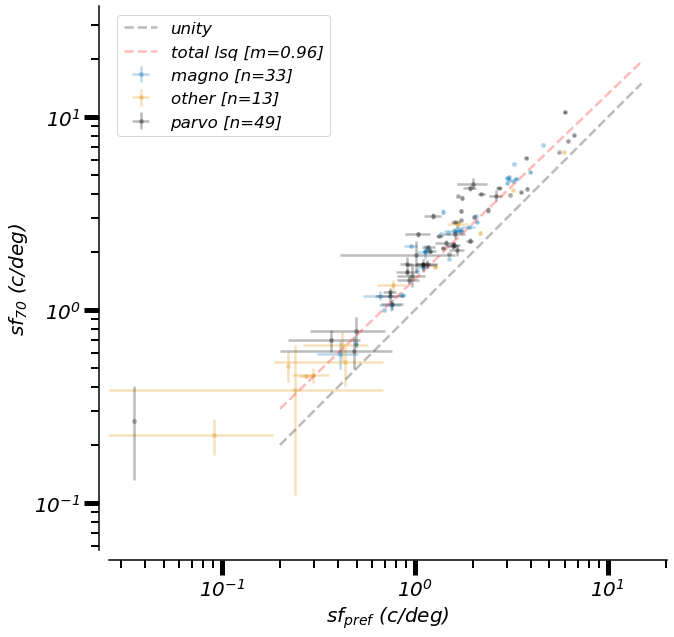

In [3127]:
saveName = '00_00_pSf_sf70_con%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(pSf), ~np.isnan(sf70));

pSf_stdLog[pSf_stdLog==0] = 1e-3
sf70_stdLog[sf70_stdLog==0] = 1e-3

mydata = odrpack.RealData(np.log10(pSf[non_nan]), np.log10(sf70[non_nan]), 
                          sx=pSf_stdLog[non_nan], sy=sf70_stdLog[non_nan])

# initial guess via simple correlation (ignoring errors)
init_guess = np.polyfit(np.log10(pSf[non_nan]), np.log10(sf70[non_nan]), deg=1)

myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
myodr.set_iprint(init=2, iter=2, final=2)
myoutput = myodr.run()
myoutput.pprint()


plt.figure(figsize=(10, 10));

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):
    ok = np.logical_and(~np.isnan(group['pSf_mn']), ~np.isnan(group['sf70_mn']));
    plt.errorbar(group['pSf_mn'], group['sf70_mn'], yerr=group['sf70_stdLog'], xerr=group['pSf_stdLog'], 
                 fmt='o', color=clr, alpha=alph, label='%s [n=%d]' % (name, len(ok)))

### Plot unity line, model; set up legend
plt.xscale('log')
plt.yscale('log')
plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=alph, label='unity');
plt.axis('equal')

xvals = np.geomspace(2e-1, 1.5e1, 100)
plt.plot(xvals, np.power(10, fn(myoutput.beta, np.log10(xvals))), 
         'r--', label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
plt.legend(fontsize='small')
plt.xlabel(r'$sf_{pref}$ (c/deg)')
plt.ylabel(r'$sf_{70}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Plot distribution of sf70 at highContrast

In [3128]:
sf70bins = np.linspace(-2, 4, 13)

In [3129]:
def bin_offsets(nBins, width):
    if np.mod(nBins,2) == 0: # i.e. even # of bins
        return width*np.linspace(-0.5-(nBins/2-1), 0.5+(nBins/2-1), nBins)
    else: # i.e. odd # of bins
        return width*np.linspace(-np.floor(nBins/2), np.floor(nBins/2), nBins)

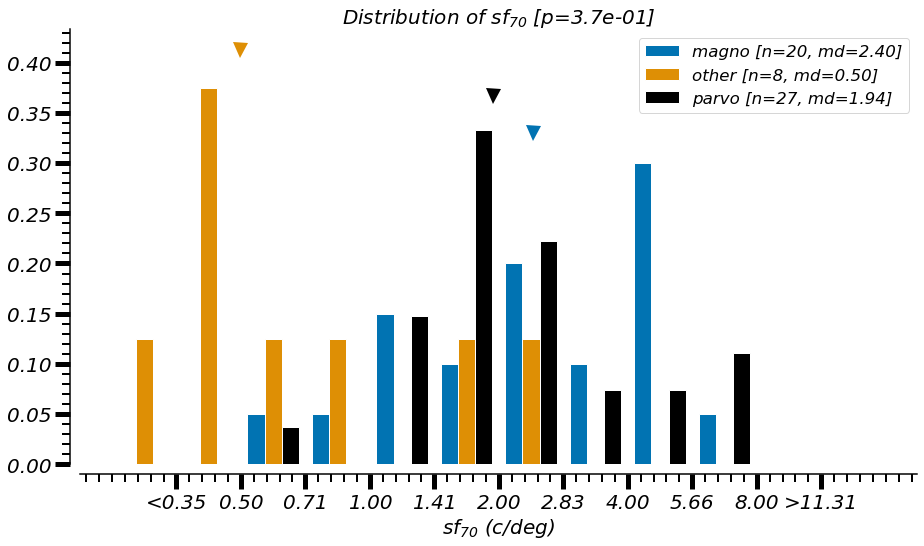

In [3130]:
# maxCon = 1; # max con...
maxCon = 0; # then we do 1/3 of max

lbl = '' if maxCon else '_third'

saveName = '00_01_sf70%s%s.pdf' % (lbl, dog_suffix_sv)

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
bins = sf70bins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(np.log2(x), clipLow, clipHigh) for x in hf.nan_rm(group['sf70_mn%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['sf70_mn%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(np.log2(mdn), 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
    
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['sf70_mn%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['sf70_mn%s' % lbl]))
    
plt.xlabel(r'$sf_{70}$ (c/deg)');
ttest = ss.ttest_ind(*to_comp);
plt.title(r'Distribution of $sf_{70}$ [p=%.1e]' % (ttest.pvalue))#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


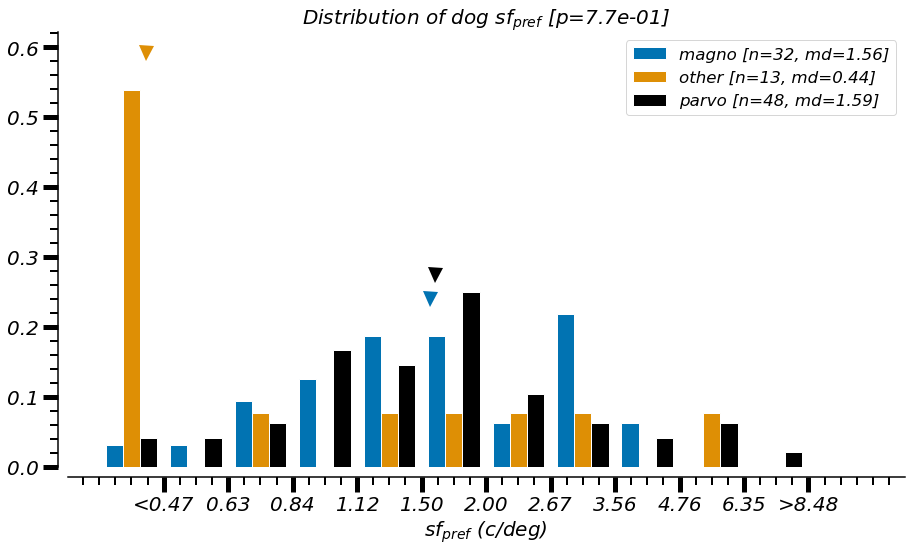

In [3131]:
saveName = '00_01alt_pSf_highCon%s.pdf' % dog_suffix_sv

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
pSfBins = np.linspace(-1.5, 3.5, 13);
bins = pSfBins#sf70bins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(np.log2(x), clipLow, clipHigh) for x in hf.nan_rm(group['pSf_mn'])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['pSf_mn']);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(np.log2(mdn), 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
   
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['pSf_mn']))
    else:
        to_comp.append(hf.nan_rm(group['pSf_mn']))
    
ttest = ss.ttest_ind(*to_comp);
plt.xlabel(r'$sf_{pref}$ (c/deg)');
plt.title(r'Distribution of $%ssf_{pref}$ [p=%.1e]' % (dog_suffix_plt, ttest.pvalue))#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Max. con gain (if LGN, only)

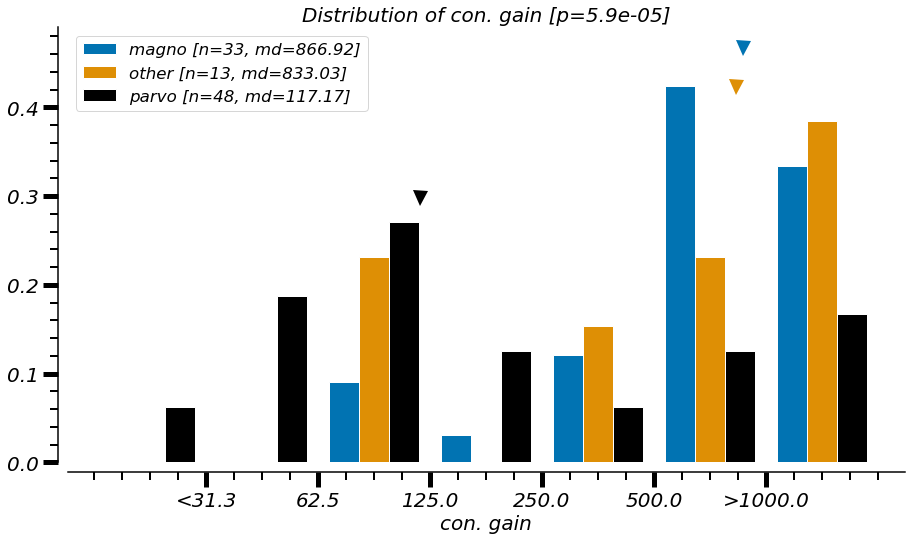

In [3132]:
if whichArea == 'LGN':
    
    conGain_bins = np.log10(np.geomspace(15.625, 2e3, 8));
    
    saveName = '00_01alt_conGain.pdf'

    plt.figure(figsize=(15, 8));

    grouped = mega.groupby(toGroup)

    # gather and calculate
    bins = conGain_bins
    stepSize = (bins[-1] - bins[0])/(len(bins)-1);
    binPlotLocs = bins[1:] - 0.5*stepSize;
    clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

    tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

    to_comp = [];
    
    width = 0.8*stepSize/cnt;
    offsets = bin_offsets(cnt, width);
    
    for (name, group), clr, widOffset in zip(grouped, colors, offsets):
        clipped = [np.clip(np.log10(x), clipLow, clipHigh) for x in hf.nan_rm(group['conGain_max'])];
        vals, _ = np.histogram(clipped, bins=bins)
        vals_norm = vals/np.sum(vals)

        # calculate
        # nSF = [len(x) for x in psfs_clipped]
        mdn = np.nanmedian(group['conGain_max']);
        # mnSF = [np.nanmean(x) for x in psfs];
        # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

        plt.plot(np.log10(mdn), 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)

        plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
                label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
        tickStrs = ['%.1f' % np.power(10, x) for x in tickVals];
        tickStrs[0] = '<%s' % tickStrs[0];
        tickStrs[-1] = '>%s' % tickStrs[-1];
        plt.xticks(tickVals, tickStrs);
        
        if len(grouped) > 2: # i.e. it's LGN...
            if name == 'other':
                continue;
            to_comp.append(hf.nan_rm(group['conGain_max']))
        else:
            to_comp.append(hf.nan_rm(group['conGain_max']))

    ttest = ss.ttest_ind(*to_comp);
    plt.xlabel('con. gain');
    plt.title('Distribution of con. gain [p=%.1e]' % ttest.pvalue)#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
    plt.legend(fontsize='small')

    sns.despine(offset=10);

    # now save
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    f = plt.gcf()
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()


##### Plot distribution of bwHalf at highContrast

In [3133]:
bwHalfbins = np.linspace(0, 6, 13);# np.linspace(0, 4, 13)

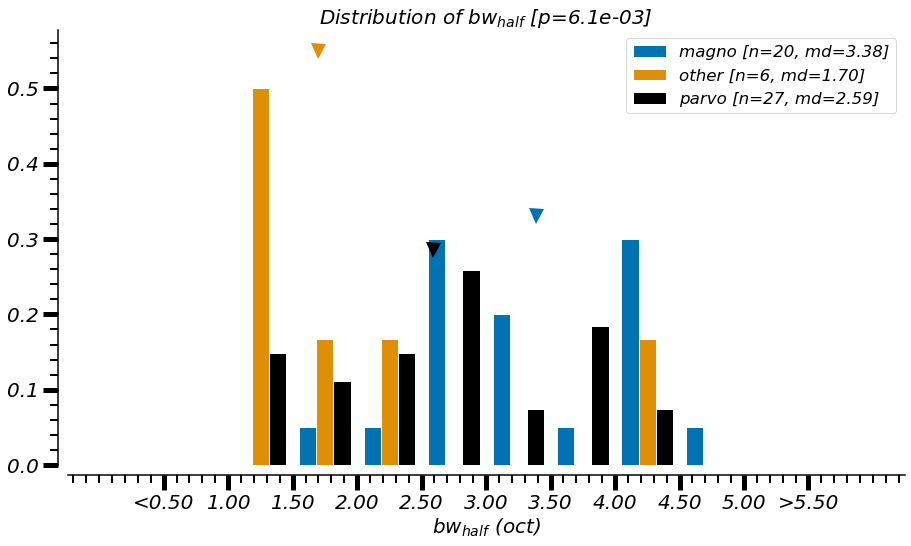

In [3134]:
# maxCon = 1; # max con...
maxCon = 0; # then we do 1/3 of max

lbl = '' if maxCon else '_third'

saveName = '00_02_bwHalf%s%s.pdf' % (lbl, dog_suffix_sv)

non_nan = ~np.isnan(pSf);

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
bins = bwHalfbins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(x, clipLow, clipHigh) for x in hf.nan_rm(group['bwHalf_mn%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['bwHalf_mn%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(mdn, 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['bwHalf_mn%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['bwHalf_mn%s' % lbl]))

ttest = ss.ttest_ind(*to_comp);
    
plt.xlabel(r'$bw_{half}$ (oct)');
plt.title(r'Distribution of $bw_{half}$ [p=%.1e]' % ttest.pvalue)#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Ask if sf70 and bwHalf are correlated?

Beta: [  9.90503843 -34.46771423]
Beta Std Error: [ 42.34829184 148.83989421]
Beta Covariance: [[ 251.18545702 -882.81014127]
 [-882.81014127 3102.85443592]]
Residual Variance: 7.139656263759767
Inverse Condition #: 0.001552379703892984
Reason(s) for Halting:
  Iteration limit reached


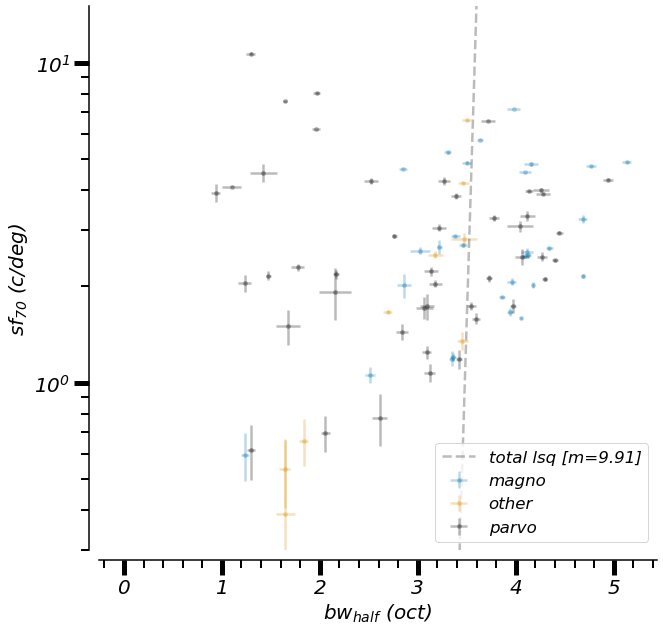

In [3135]:
saveName = '00_03a_bwHalf_sf70%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(bwHalf), ~np.isnan(sf70));

sf70[sf70_stdLog==0] = 1e-3
bwHalf_std[bwHalf_std==0] = 1e-3

mydata = odrpack.RealData(bwHalf[non_nan], np.log10(sf70[non_nan]), 
                          sx=bwHalf_std[non_nan], sy=sf70_stdLog[non_nan])

# initial guess via simple correlation (ignoring errors)
init_guess = np.polyfit(bwHalf[non_nan], np.log10(sf70[non_nan]), deg=1)

myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
myodr.set_iprint(init=2, iter=2, final=2)
myoutput = myodr.run()
myoutput.pprint()


plt.figure(figsize=(10, 10));

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):
    plt.errorbar(group['bwHalf_mn'], group['sf70_mn'], yerr=group['sf70_stdLog'], xerr=0.1*group['bwHalf_std'], 
                 fmt='o', alpha=alph, label=name, color=clr)

### Plot unity line, model; set up legend
# plt.xscale('log')
plt.yscale('log')
plt.ylim([3e-1, 1.5e1])
# plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=0.3, label='unity');

xvals = np.linspace(0, 5, 100)
plt.plot(xvals, np.power(10, fn(myoutput.beta, xvals)), 
         'k--', label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
plt.legend(fontsize='small')
plt.xlabel(r'$bw_{half}$ (oct)')
plt.ylabel(r'$sf_{70}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


Beta: [1.15945755 3.55881912]
Beta Std Error: [0.5474457  0.19714804]
Beta Covariance: [[ 0.0724779  -0.02202007]
 [-0.02202007  0.00939958]]
Residual Variance: 4.135009252189388
Inverse Condition #: 0.16662116117703307
Reason(s) for Halting:
  Sum of squares convergence
Beta: [1.69022919 2.35608221]
Beta Std Error: [0.3210611  0.15233774]
Beta Covariance: [[ 0.23634884 -0.05925969]
 [-0.05925969  0.05320998]]
Residual Variance: 0.4361359693665768
Inverse Condition #: 0.3857845272403521
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-1.87041627  3.78420236]
Beta Std Error: [0.62142541 0.3301864 ]
Beta Covariance: [[ 0.06589791 -0.03005737]
 [-0.03005737  0.01860424]]
Residual Variance: 5.860117998835412
Inverse Condition #: 0.017856801192763658
Reason(s) for Halting:
  Sum of squares convergence


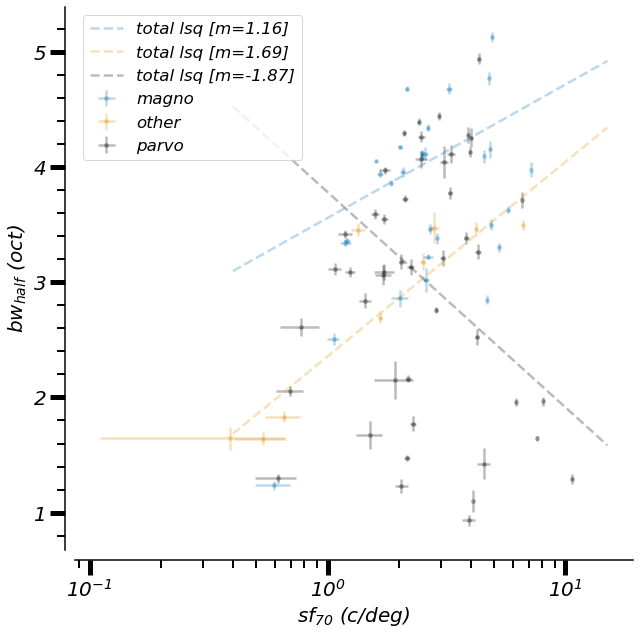

In [3136]:
saveName = '00_03b_sf70_bwHalf%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(bwHalf), ~np.isnan(sf70));

pSf_stdLog[pSf_stdLog==0] = 1e-3


plt.figure(figsize=(10, 10));

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):
    plt.errorbar(group['sf70_mn'], group['bwHalf_mn'], xerr=group['sf70_stdLog'], yerr=0.1*group['bwHalf_std'], 
                 fmt='o', alpha=alph, label=name, color=clr)
    
    nn = np.logical_and(~np.isnan(group['sf70_mn']), ~np.isnan(group['bwHalf_mn']));
    
    
    mydata = odrpack.RealData(np.log10(group['sf70_mn'][nn]), group['bwHalf_mn'][nn], 
                              sy=group['bwHalf_std'][nn], sx=group['sf70_stdLog'][nn])

    # initial guess via simple correlation (ignoring errors)
    init_guess = np.polyfit(np.log10(group['sf70_mn'][nn]), group['bwHalf_mn'][nn], deg=1)

    myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
    myodr.set_iprint(init=2, iter=2, final=2)
    myoutput = myodr.run()
    myoutput.pprint()

    xvals = np.geomspace(4e-1, 1.5e1, 100)
    plt.plot(xvals, fn(myoutput.beta, np.log10(xvals)), 
             '--', color=clr, label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
    

### Plot unity line, model; set up legend
plt.xscale('log')
# plt.yscale('log')
# plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=0.3, label='unity');

plt.legend(fontsize='small')
plt.ylabel(r'$bw_{half}$ (oct)')
plt.xlabel(r'$sf_{70}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


## 1. Shifts with contrast

##### First, let's compute the ratios (and std. of ratios)

In [3137]:
def match_lengths(x):
    # fill with NaN to make sure that all lists in the array have the same length
    max_len = np.max([len(xp) for xp in x])
    for i, xp in enumerate(x):
        if len(xp) < max_len:
            tmp = np.nan * np.zeros((max_len, ));
            tmp[0:len(xp)] = xp
            x[i] = tmp
            
    return np.stack(x)

In [3138]:
### First, ratios/diffs at one-third contrast

sf70, sf70_third, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_%ssf70_values' % dog_suffix, whichMod=isDog, atLowest=0, returnBothCons=True)
bwHalf, bwHalf_third, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_%sbwHalf_values' % dog_suffix, whichMod=isDog, atLowest=0, returnBothCons=True)

sf70 = match_lengths(sf70)
sf70_third = match_lengths(sf70_third)
bwHalf = match_lengths(bwHalf)
bwHalf_third = match_lengths(bwHalf_third)

for i, lbl in enumerate(['', '_norm']):
    
    if i == 0:
        conRat = 1;
    else:
        conRat = np.log2(np.divide(hiCon, loCon))

        
    sf70_rats = np.divide(np.nanmean(np.log2(np.divide(sf70, sf70_third)), axis=1), conRat)
    sf70_rats_std = np.divide(np.nanstd(np.log2(np.divide(sf70, sf70_third)), axis=1), conRat)
    bwHalf_diffs = np.divide(np.nanmean(np.subtract(bwHalf, bwHalf_third), axis=1), conRat)
    bwHalf_diffs_std = np.divide(np.nanstd(np.subtract(bwHalf, bwHalf_third), axis=1), conRat)

    mega['boot_sf70_rats_third%s' % lbl] = sf70_rats
    mega['boot_sf70_rats_std_third%s' % lbl] = sf70_rats_std
    mega['boot_bwHalf_diffs_third%s' % lbl] = bwHalf_diffs
    mega['boot_bwHalf_diffs_std_third%s' % lbl] = bwHalf_diffs_std

### Then, ratios/diffs at lowest valid

sf70, sf70_lo, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_sf70_values', whichMod=isDog, atLowest=1, returnBothCons=True)
bwHalf, bwHalf_lo, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_bwHalf_values', whichMod=isDog, atLowest=1, returnBothCons=True)

sf70 = match_lengths(sf70)
sf70_lo = match_lengths(sf70_lo)
bwHalf = match_lengths(bwHalf)
bwHalf_lo = match_lengths(bwHalf_lo)

for i, lbl in enumerate(['', '_norm']):
    
    if i == 0:
        conRat = 1;
    else:
        conRat = np.log2(np.divide(hiCon, loCon))

    sf70_rats = np.divide(np.nanmean(np.log2(np.divide(sf70, sf70_lo)), axis=1), conRat)
    sf70_rats_std = np.divide(np.nanstd(np.log2(np.divide(sf70, sf70_lo)), axis=1), conRat)
    bwHalf_diffs = np.divide(np.nanmean(np.subtract(bwHalf, bwHalf_lo), axis=1), conRat)
    bwHalf_diffs_std = np.divide(np.nanstd(np.subtract(bwHalf, bwHalf_lo), axis=1), conRat)

    mega['boot_sf70_rats_lowest%s' % lbl] = sf70_rats
    mega['boot_sf70_rats_std_lowest%s' % lbl] = sf70_rats_std
    mega['boot_bwHalf_diffs_lowest%s' % lbl] = bwHalf_diffs
    mega['boot_bwHalf_diffs_std_lowest%s' % lbl] = bwHalf_diffs_std

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:3656: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  cellSummaries = pool.map(perCell_summary, range(nCells));
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


#### 1.01 - sfPref across contrast (ratio, as hist)

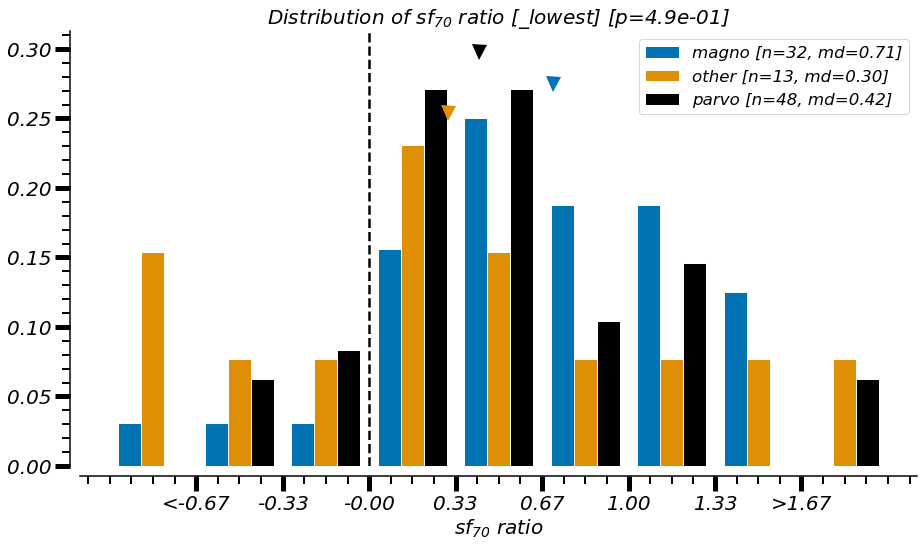

In [3139]:
fixedCon = 0; # if fixed con., then eval. at one third; otherwise, lowest valid con.
norm = 0; # normalize?

lbl = '_third' if fixedCon else '_lowest'
lbl = '%s_norm' % lbl if norm else '%s' % lbl

saveName = '01_01_sf70_rat%s%s.pdf' % (lbl, dog_suffix_sv)

if norm:
    sf70bins_ratio = np.linspace(-0.5,1,10)
else:
    sf70bins_ratio = np.linspace(-1,2,10)

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
bins = sf70bins_ratio
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(x, clipLow, clipHigh) for x in hf.nan_rm(group['boot_sf70_rats%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['boot_sf70_rats%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(mdn, 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
#     tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
    
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['boot_sf70_rats%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['boot_sf70_rats%s' % lbl]))

    
plt.xlabel(r'$sf_{70}$ ratio');
ttest = ss.ttest_ind(*to_comp);
plt.title(r'Distribution of $sf_{70}$ ratio [%s] [p=%.01e]' % (lbl, ttest.pvalue))
#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')
plt.axvline(0, color='k', linestyle='--')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


#### 1.02 bandwidth across contrast (diff, as hist)

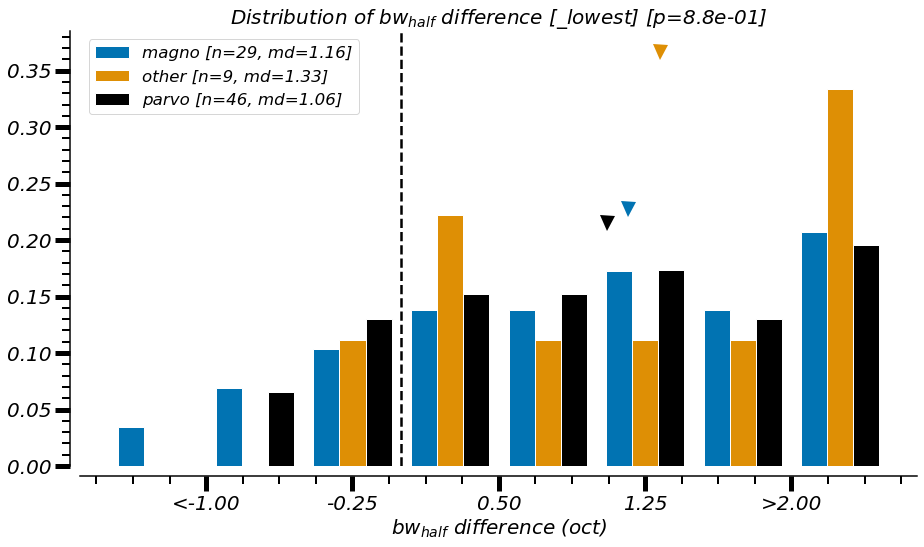

In [3140]:
fixedCon = 0; # if fixed con., then eval. at one third; otherwise, lowest valid con.
norm = 0; # normalize?

lbl = '_third' if fixedCon else '_lowest'
lbl = '%s_norm' % lbl if norm else '%s' % lbl

saveName = '01_02_bwHalf_diff%s%s.pdf' % (lbl, dog_suffix_sv)

if norm:
    bwHalfbins_ratio = np.linspace(-0.5, 0.7, 13);
else:
    bwHalfbins_ratio = np.linspace(-1.5, 2.5, 9);

plt.figure(figsize=(15, 8));

bins = bwHalfbins_ratio
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], 5);
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(x, clipLow, clipHigh) for x in hf.nan_rm(group['boot_bwHalf_diffs%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['boot_bwHalf_diffs%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(mdn, 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
    
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['boot_bwHalf_diffs%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['boot_bwHalf_diffs%s' % lbl]))
    
plt.xlabel(r'$bw_{half}$ difference (oct)');
ttest = ss.ttest_ind(*to_comp);
plt.title(r'Distribution of $bw_{half}$ difference [%s] [p=%.01e]' % (lbl, ttest.pvalue))
#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')
plt.axvline(0, color='k', linestyle='--')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


In [3141]:
#### 1.03 sf70 against sf70 across contrast

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/plevy/miniconda

Beta: [0.14227217 0.0640243 ]
Beta Std Error: [0.03175765 0.01532137]
Beta Covariance: [[ 0.00093495 -0.00027297]
 [-0.00027297  0.00021761]]
Residual Variance: 1.0787234835761426
Inverse Condition #: 0.35433602854637725
Reason(s) for Halting:
  Sum of squares convergence
Beta: [0.32212965 0.12503119]
Beta Std Error: [0.1499592  0.06271754]
Beta Covariance: [[0.00824405 0.00261185]
 [0.00261185 0.00144202]]
Residual Variance: 2.7277580016153298
Inverse Condition #: 0.24001058288750804
Reason(s) for Halting:
  Sum of squares convergence
Beta: [0.16112084 0.03666789]
Beta Std Error: [0.05889017 0.03061977]
Beta Covariance: [[ 0.00546151 -0.00232091]
 [-0.00232091  0.00147649]]
Residual Variance: 0.6349981873414939
Inverse Condition #: 0.006528989649466991
Reason(s) for Halting:
  Sum of squares convergence


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2041: ResourceWarning: unclosed file <_io.BufferedWriter name='/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/figures/reports/ch1/LGN_211011_vT60_dvT60/02_01_trajIndiv_dog_sf70/LGN_09.pdf'>
  for attr in kwargs:


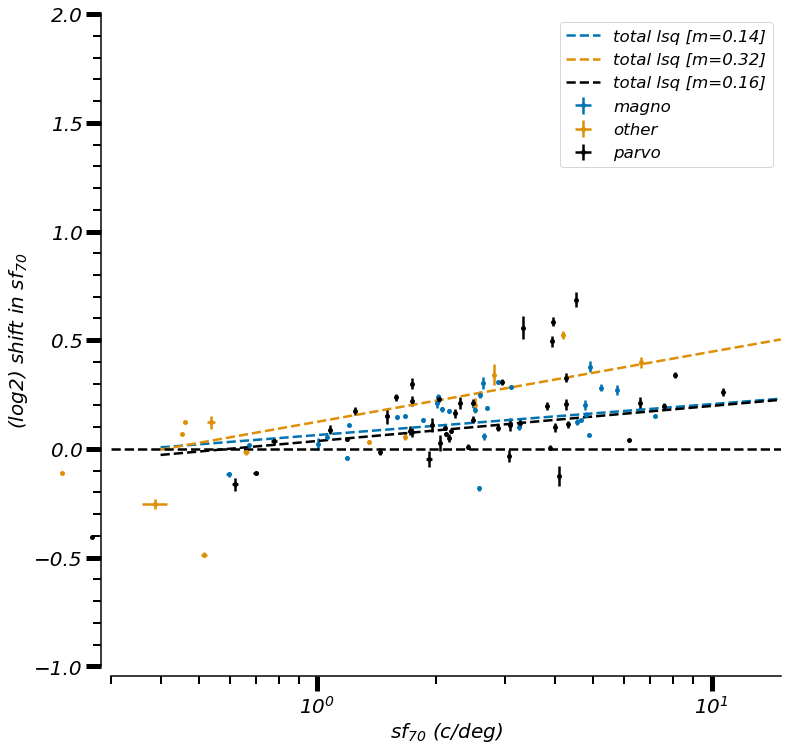

In [3142]:
fixedCon = 0; # if fixed con., then eval. at one third; otherwise, lowest valid con.
norm = 1; # normalize?

lbl = '_third' if fixedCon else '_lowest'
lbl = '%s_norm' % lbl if norm else '%s' % lbl

saveName = '01_03_sf70_v_sf70_rats%s%s.pdf' % (lbl, dog_suffix_sv)

plt.figure(figsize=(12,12))

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):

    plt.errorbar(group['sf70_mn'], group['boot_sf70_rats%s' % lbl],
            xerr=0.1*group['sf70_stdLog'], yerr=0.1*group['boot_sf70_rats_std%s' % lbl], fmt='o',
                 color=clr, clip_on=False,
                 label=name, alpha=1)
    
    nn = np.logical_and(~np.isnan(group['sf70_mn']), ~np.isnan(group['boot_sf70_rats%s' % lbl]));
    
    ### HACKY!! Manually setting any
    ky = 'sf70_stdLog'
    group[ky][group[ky]==0] = 1e-3;
    ky = 'boot_sf70_rats_std%s' % lbl
    group[ky][group[ky]==0] = 1e-3;
    
    mydata = odrpack.RealData(np.log10(group['sf70_mn'][nn]), group['boot_sf70_rats%s' % lbl][nn], 
                              sy=group['boot_sf70_rats_std%s' % lbl][nn], sx=group['sf70_stdLog'][nn])

    # initial guess via simple correlation (ignoring errors)
    init_guess = np.polyfit(np.log10(group['sf70_mn'][nn]), group['boot_sf70_rats%s' % lbl][nn], deg=1)

    myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
    myodr.set_iprint(init=2, iter=2, final=2)
    myoutput = myodr.run()
    myoutput.pprint()

    xvals = np.geomspace(4e-1, 1.5e1, 100)
    plt.plot(xvals, fn(myoutput.beta, np.log10(xvals)),
             '--', color=clr, clip_on=False, label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=1);
    
    
plt.xlabel(r'$sf_{70}$ (c/deg)')
plt.ylabel(r'(log2) shift in $sf_{70}$')
    
plt.xscale('log')
plt.axhline(0, color='k', linestyle='--');
plt.xlim([3e-1, 1.5e1]);
plt.ylim([-1, 2]);
plt.legend(fontsize='small');

sns.despine(offset=10)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

## 2. Shifts with contrast, refined view
Per discussion in VNL, we should try (or rather, revive) to consider the whole trajectory of sf70 (or bandwidth, or else) with contrast

### 01. Plot metric (e.g. sf70) against contrast - for all cells separately and then together

In [3143]:
import scipy.optimize as opt

In [3144]:
def fn(x, a, b):
    return b + a*x;
#     return b + np.log10(a)*np.log10(x);


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
No handles with labels found to put in legend.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

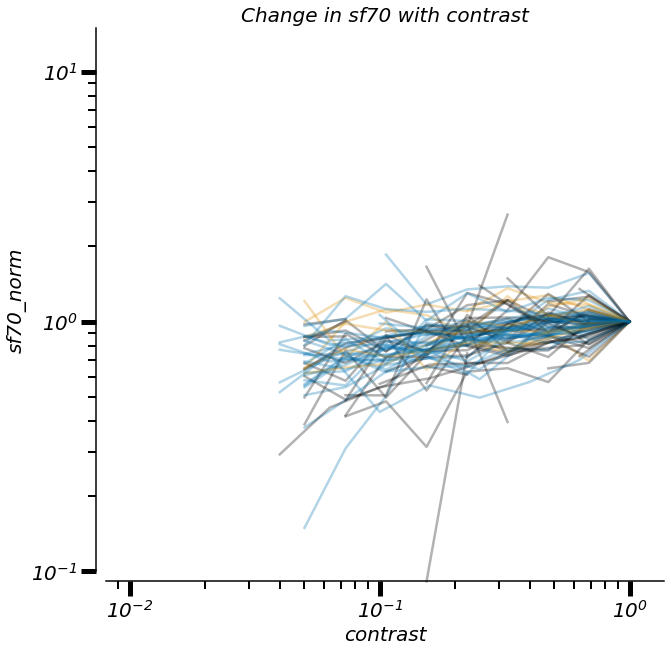

In [3150]:
metr = 'sf70'
metrIsLog = 1; # is this metric log?

norm = 1; # normalized?
norm_suffix = '_norm' if norm else '';

ylim = [1e-1, 1.5e1]

isDog = 1;
dog_suffix = 'dog_' if isDog else ''

# Mostly unchanged
disp = 0; # unchanged!
xlim = [1e-2, 1.1]; # contrast
low, ctr, high = 2.5, 50, 97.5; # get median, and bounds for 95% C.I.

mega_figure = plt.figure(figsize=(10,10));

# names for savig
save_loc_indiv = save_loc + '02_01_trajIndiv_%s%s/' % (dog_suffix, metr)
# -- individual name will be made within the loop
saveName = '02_01_traj_%s%s%s.pdf' % (dog_suffix, metr, norm_suffix)

reg_slopes = np.nan * np.zeros((len(mega['cellType']), 2)); # we'll store the param. and it's std.

for ky in range(len(mega['cellType'])):
    
    plt.figure(figsize=(12, 12));
    
    curr_dir = mega['fullPath'][ky].split('/')[-3]
    curr_num = mega['cellNum'][ky];
    curr_name = '' if 'sach' in curr_dir else mega['expName'][ky];
    curr_type = mega['triType'][ky] if whichArea=='LGN' else mega['simple'][ky];
    title = '%s #%02d:%s [%s]' % (curr_dir, curr_num, curr_name, curr_type)

    # get which contrasts will be plotting, corresponding indices
    curr_cons = mega['stimVals'][ky][1]; # 1 is for contrast values
    val_inds = mega['val_con_by_disp'][ky][disp]; # should always zero disp
    
    mtr = 'boot_%s%s_values' % (dog_suffix, metr)
           
    # then get the metric of interest
    curr_vals = mega[mtr][ky][disp, val_inds]
    curr_med, curr_low, curr_high = np.nanpercentile(curr_vals, [low, ctr, high], axis=1)
    curr_errs = [curr_low, curr_high] - curr_med

    # -- get the right color
    clr = colors[grp_names.index(curr_type)];
    
    # and plot!
    plt.scatter(curr_cons[val_inds], curr_med, color=clr, clip_on=False);
    plt.errorbar(curr_cons[val_inds], curr_med, curr_errs, color=clr, clip_on=False);
    # -- with linear regression (on log-log, assuming both dims are log)
    ok_for_reg = np.where(~np.isnan(curr_med))[0];
    if len(ok_for_reg) > 1:
        mtr_var = 'boot_%s%s_%s' % (dog_suffix, metr, var_suffix)
        curr_var = mega[mtr_var][ky][disp, val_inds]

        fine = opt.curve_fit(fn, np.log10(curr_cons[val_inds][ok_for_reg]), np.log10(curr_med[ok_for_reg]), 
                             sigma=curr_var[ok_for_reg])
        pmz = fine[0];
        perr = np.sqrt(np.diag(fine[1])); # per https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
        conz = np.geomspace(curr_cons[val_inds][ok_for_reg][0], curr_cons[val_inds][ok_for_reg][-1], 50);
        reg_slopes[ky] = [pmz[0], perr[0]];
        plt.plot(conz, np.power(10, fn(np.log10(conz), *pmz)), 'k--', label=r'$m=%.2f \pm %.2f$' % (pmz[0], perr[0]))
    
    # adjust figure
    plt.xscale('log');
    plt.xlabel('contrast');
    if metrIsLog:
        plt.yscale('log');
        plt.axis('equal');
    plt.ylim(ylim);
    plt.xlim(xlim);
    plt.ylabel('%s' % metr);

    plt.legend(fontsize='x-small')
    
    plt.title('%s' % title);
    sns.despine(offset=10);
    
    # Save the current one
    saveName_indiv = '%s_%02d.pdf' % (curr_dir, curr_num)
    
    if not os.path.exists(save_loc_indiv):
        os.makedirs(save_loc_indiv)
    pdfSv = pltSave.PdfPages(save_loc_indiv + saveName_indiv);
    f = plt.gcf();
    pdfSv.savefig(f); # only one figure here...
    pdfSv.close();
    plt.clf(); # close the plot
    
    # replot on the first one, too
    plt.figure(1);
    if norm:
        try:
            # normalize by the metric value at the highest valid contrast
            norm_ind = np.where(~np.isnan(curr_med))[0][-1];
            curr_med_norm = np.divide(curr_med, curr_med[norm_ind])
            plt.plot(curr_cons[val_inds], curr_med_norm, color=clr, clip_on=False, alpha=0.3)
#             plt.errorbar(curr_cons[val_inds], curr_med_norm, curr_errs, color=clr, clip_on=False, alpha=0.3)
        except:
            pass
    else:
        plt.plot(curr_cons[val_inds], curr_med, color=clr, clip_on=False, alpha=0.3)
#         plt.errorbar(curr_cons[val_inds], curr_med, curr_errs, color=clr, clip_on=False, alpha=0.3)

# at the end, fix up the overall figure
plt.figure(1);

plt.xscale('log');
plt.xlabel('contrast')
if metrIsLog:
    plt.yscale('log')
    plt.axis('equal')
plt.ylim(ylim);
plt.xlim(xlim);
plt.ylabel('%s%s' % (metr, norm_suffix))
plt.title('Change in %s with contrast' % metr)

sns.despine(offset=10)

# Save the overall plot
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()
# plt.clf() # close the plot


# And save the slopes in the overall structure
mega['conSlope_%s%s' % (dog_suffix, metr)] = reg_slopes

##### Alternative version which uses mean + std (as opposed to confidence intervals)

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/users/plevy/miniconda3/

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

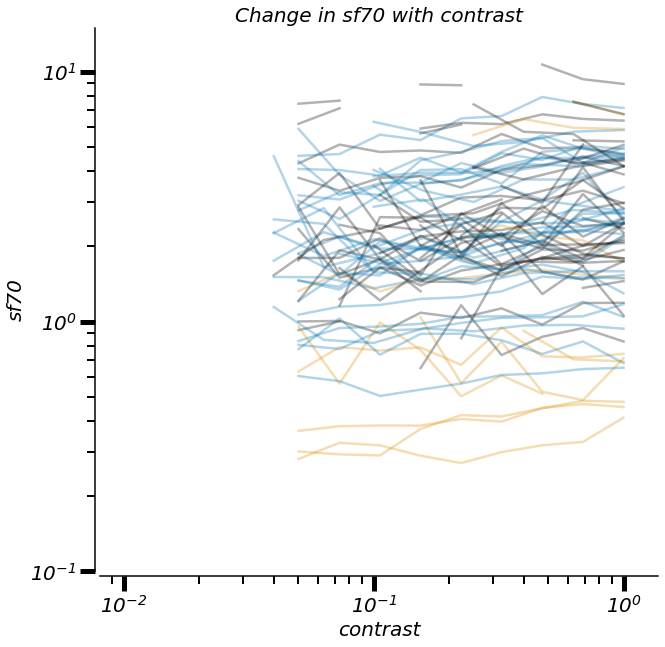

In [3185]:
metr = 'sf70'
metrIsLog = 1; # is this metric log?
var_suffix = 'stdLog' if metrIsLog else 'std';

norm = 0; # normalized?
norm_suffix = '_norm' if norm else '';

ylim = [0.25, 4] if norm else [1e-1, 1.5e1]

isDog = 1;
dog_suffix = 'dog_' if isDog else ''

# Mostly unchanged
disp = 0; # unchanged!
xlim = [1e-2, 1.1]; # contrast

mega_figure = plt.figure(figsize=(10,10));

errMult = 1.96; # 1.96 _should_ be 95% CI; otherwise, just use 1

# names for savig
save_loc_indiv = save_loc + '02_01alt_trajIndiv_%s%s/' % (dog_suffix, metr)
# -- individual name will be made within the loop
saveName = '02_01alt_traj_%s%s%s.pdf' % (dog_suffix, metr, norm_suffix)

for ky in range(len(mega['cellType'])):
    
    plt.figure(figsize=(10, 10));
    
    curr_dir = mega['fullPath'][ky].split('/')[-3]
    curr_num = mega['cellNum'][ky];
    curr_name = '' if 'sach' in curr_dir else mega['expName'][ky];
    curr_type = mega['triType'][ky] if whichArea=='LGN' else mega['simple'][ky];
    title = '%s #%02d:%s [%s]' % (curr_dir, curr_num, curr_name, curr_type)

    # get which contrasts will be plotting, corresponding indices
    curr_cons = mega['stimVals'][ky][1]; # 1 is for contrast values
    val_inds = mega['val_con_by_disp'][ky][disp]; # should always zero disp
    
    mtr_mn = 'boot_%s%s_mn' % (dog_suffix, metr)
    
    mtr_var = 'boot_%s%s_%s' % (dog_suffix, metr, var_suffix)
        
    # then get the metric of interest
    curr_vals = mega[mtr_mn][ky][disp, val_inds];
    curr_errs = mega[mtr_var][ky][disp, val_inds];
    
    clr = colors[grp_names.index(curr_type)];
    
    plt.scatter(curr_cons[val_inds], curr_vals, color=clr, clip_on=False);
    plt.errorbar(curr_cons[val_inds], curr_vals, errMult*curr_errs, color=clr, clip_on=False);
        
    plt.xscale('log');
    plt.xlabel('contrast');
    if metrIsLog:
        plt.yscale('log');
        plt.axis('equal');
    plt.ylim(ylim);
    plt.xlim(xlim);
    plt.ylabel('%s' % metr);

    plt.title('%s' % title);
    sns.despine(offset=5);
    
    # Save the current one
    saveName_indiv = '%s_%02d.pdf' % (curr_dir, curr_num)
    
    if not os.path.exists(save_loc_indiv):
        os.makedirs(save_loc_indiv);
    pdfSv = pltSave.PdfPages(save_loc_indiv + saveName_indiv);
    f = plt.gcf();
    pdfSv.savefig(f); # only one figure here...
    pdfSv.close();
    plt.clf(); # close the plot
    
    # replot on the first one, too
    plt.figure(1);
    if norm:
        try:
            # normalize by the metric value at the highest valid contrast
            norm_ind = np.where(~np.isnan(curr_vals))[0][-1];
            curr_vals_norm = np.divide(curr_vals, curr_vals[norm_ind])
            plt.plot(curr_cons[val_inds], curr_vals_norm, color=clr, clip_on=False, alpha=0.3);
        except:
            pass
    else:
        plt.plot(curr_cons[val_inds], curr_vals, color=clr, clip_on=False, alpha=0.3);

# at the end, fix up the overall figure
plt.figure(1);

plt.xscale('log');
plt.xlabel('contrast');
if metrIsLog:
    plt.yscale('log');
    plt.axis('equal');
plt.ylim(ylim);
plt.xlim(xlim);
plt.ylabel('%s%s' % (metr, norm_suffix));
plt.title('Change in %s with contrast' % metr);

sns.despine(offset=5);

# Save the overall plot
if not os.path.exists(save_loc):
    os.makedirs(save_loc);
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf();
pdfSv.savefig(f); # only one figure here...
pdfSv.close();
# plt.clf() # close the plot


##### Plot the regression slopes we fit above

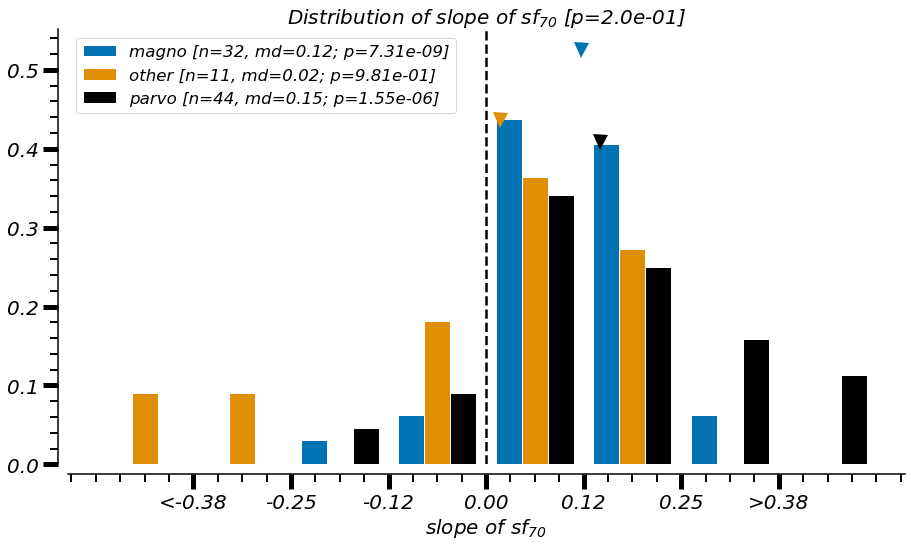

In [3182]:
saveName = '02_01_%s%s_slopes.pdf' % (dog_suffix, metr)

no_effect = 0; # i.e. if the slope is 0, then there's no effect

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
bins = np.linspace(-0.5, 0.5, 9);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    
    vals_no_nan = hf.nan_rm(group['conSlope_%s%s' % (dog_suffix, metr)])
    
    clipped = [np.clip(x, clipLow, clipHigh) for x in vals_no_nan];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(vals_no_nan);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(mdn, 1.2*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    pval_curr = ss.ttest_1samp(vals_no_nan, no_effect) # check if the slopes are diff. from, e.g. 0
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f; p=%.2e]' % (name, np.sum(vals), mdn, pval_curr.pvalue), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
#     tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
    
    
    
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['conSlope_%s%s' % (dog_suffix, metr)]))
    else:
        to_comp.append(hf.nan_rm(group['conSlope_%s%s' % (dog_suffix, metr)]))
    
# unity/no effect line
plt.axvline(no_effect, color='k', linestyle='--')

plt.xlabel(r'slope of $sf_{70}$');
ttest = ss.ttest_ind(*to_comp);
plt.title(r'Distribution of slope of $sf_{70}$ [p=%.1e]' % (ttest.pvalue))
plt.legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


### 02. Plot ratio of metric (e.g. sf70) hi:X contrast - for all cells separately and then together